In [1]:
from IPython.display import display, HTML
display(HTML("""
<style>
div.container{width:90% !important;}
div.cell.code_cell.rendered{width:90%;}
div.input_prompt{padding:0px;}
div.CodeMirror {font-family:Consolas; font-size:10pt;}
div.text_cell_render.rendered_html{font-size:11pt;}
div.output {font-size:10pt; font-weight:bold;}
div.input {font-family:Consolas; font-size:10pt;}
div.prompt {min-width:70px;}
div#toc-wrapper{padding-top:120px;}
div.text_cell_render ul li{font-size:10pt;padding:5px;}
table.dataframe{font-size:10px;}
</style>
"""))

<b><font size="6" color="red">Ch 09. Red Wine 품질 등급 예측 실습</font><b>

* 1. 데이터셋 확보 & 전처리
독립변수와 타겟변수 분리 -> 독립변수 스케일조정(StandardScaler)
→ 타겟변수원핫인코딩(get_dummies) -> 훈련셋과 테스트셋분리(train_test_split)
* 2. 모델 구성(입력11, 출력?)
* 3. 모델학습과정 설정(다중분류로 설정)
* 4. 모델 학습(callbacks 이용)
* 5. 모델평가 - 그래프, 평가(테스셋), 교차표
* 6. 모델 저장/ 사용

In [16]:
import numpy as np
import pandas as pd # read_csv, get_dummies
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential, save_model, load_model
from tensorflow.keras.layers import Input, Dense, Dropout, LeakyReLU
from tensorflow.keras.metrics import Recall, Precision
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, Callback

# 1. 데이터셋 확보 & 전처리

```고정 산도(fixed acidity)
휘발성 산도(volatile acidity)
구연산(citric acid)
잔여 당분(residual sugar)
염화물(chlorides)
유리 아황산염(free sulfur dioxide)
총 아황산염(total sulfur dioxide)
밀도(density)
pH
황산염(sulphates)
알코올(alcohol)
```

In [3]:
#데이터 읽어오기
redwine = pd.read_csv('./data/winequality-red.csv', sep=';')
redwine.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [6]:
# 타겟변수의 균형
redwine['quality'].value_counts(normalize=True)

5    0.425891
6    0.398999
7    0.124453
4    0.033146
8    0.011257
3    0.006254
Name: quality, dtype: float64

In [4]:
# 독립변수, 타깃변수 분리
X_redwine = redwine.iloc[:, :-1].values # == to_numpy
y_redwine = redwine.iloc[:, -1]
X_redwine.shape, y_redwine.shape

((1599, 11), (1599,))

In [5]:
# 독립변수 X의 스케일 조정
scaler = StandardScaler()
scaled_X = scaler.fit_transform(X_redwine)
# 다중 분류를 위한 타깃변수의 원핫인코딩 : 넘파이 배열로 변환
Y_redwine = pd.get_dummies(y_redwine).to_numpy()

In [10]:
print('원 데이터 → 원핫인코딩')
# 0번째 인덱스가 3등급(get_dummies() - 확인된 데이터들만 원핫인코딩(0~2는 없는 데이터))
np.column_stack([y_redwine[3:5], Y_redwine[3:5]])

원 데이터 → 원핫인코딩


array([[6, 0, 0, 0, 1, 0, 0],
       [5, 0, 0, 1, 0, 0, 0]], dtype=int64)

In [14]:
# 독립변수: scaled_X_redwine & 타깃변수 : Y_redwine
scaled_X.shape, Y_redwine.shape

((1599, 11), (1599, 6))

In [11]:
# 훈련셋과 테스트셋 분리(7:3 층화추출)
X_train, X_test, Y_train, Y_test = train_test_split(scaled_X, Y_redwine, 
                                                    #test_size=0.3, 
                                                    train_size=0.7, 
                                                    stratify=Y_redwine, #층화 추출
                                                    random_state=12)
X_train.shape, Y_train.shape, X_test.shape, Y_test.shape

((1119, 11), (1119, 6), (480, 11), (480, 6))

In [14]:
# 층화추출 잘 됐는지?
np.c_[pd.Series(Y_redwine.argmax(axis=1)).value_counts(normalize=True), 
      pd.Series(Y_train.argmax(axis=1)).value_counts(normalize=True), 
      pd.Series(Y_test.argmax(axis=1)).value_counts(normalize=True)]
# == np.column_stack

array([[0.42589118, 0.42627346, 0.425     ],
       [0.39899937, 0.39857015, 0.4       ],
       [0.12445278, 0.12421805, 0.125     ],
       [0.03314572, 0.03306524, 0.03333333],
       [0.01125704, 0.01161752, 0.01041667],
       [0.00625391, 0.00625559, 0.00625   ]])

# 2. 모델 구성 (입력11, 출력6)

In [23]:
model = Sequential()
model.add(Input(11))
model.add(Dense(units=50, activation='relu')) # input 11 → 50 relu
model.add(Dense(units=50, activation='relu')) # 50 → 50 relu
model.add(Dropout(0.1))
model.add(Dense(30, 'relu')) # 50 → 30 relu
model.add(Dense(6, 'softmax')) # 30 → 6 output softmax
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 50)                600       
                                                                 
 dense_5 (Dense)             (None, 50)                2550      
                                                                 
 dropout_1 (Dropout)         (None, 50)                0         
                                                                 
 dense_6 (Dense)             (None, 30)                1530      
                                                                 
 dense_7 (Dense)             (None, 6)                 186       
                                                                 
Total params: 4,866
Trainable params: 4,866
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Parameter 수 이해
# 600 : 11 * 50 + 50
# 2550 : 50 * 50 + 50
# 1530 : 50 * 30 + 30
# 186 : 30 * 6 + 6

# 3. 모델 학습과정 설정 (다중분류에 맞게)

In [24]:
model.compile(loss='categorical_crossentropy',
             optimizer='adam',
             metrics=['accuracy'])

class CustomHistory(Callback): # on_epoch_end() 함수가 epoch 수행 후 자동 호출
    def __init__(self):
        self.epoch = 0
    def on_epoch_end(self, batch, logs={}):
        self.epoch += 1
        if (self.epoch%5 == 0) | (self.epoch == 1):
            print('{}번째 loss: {:.4f}, acc: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}'.format(self.epoch, 
                                                                                              logs.get('loss'), 
                                                                                              logs.get('accuracy'), 
                                                                                              logs.get('val_loss'), 
                                                                                              logs.get('val_accuracy')
                                                                                             )
                 )
customHistory = CustomHistory()
import os
model_save_folder = './model09/'
if not os.path.exists(model_save_folder): # 폴더가 없으면 폴더 생성
    os.mkdir(model_save_folder)
file = model_save_folder + 'wine-{epoch:03d}-loss{val_loss:.4f}-acc{val_accuracy:.4f}.h5'
checkpoint = ModelCheckpoint(
                filepath = file,
                monitor='val_accuracy', #모니터할 지표(기본값 val_loss)
                save_best_only=True,    # 모니터링 지표가 개선된 경우만 저장
                mode = 'max', # 값이 클수록 저장
                verbose=0)
earlyStopping = EarlyStopping(monitor='val_loss', patience=20)

# 4. 학습시키기 (callbacks 이용)

In [25]:
%%time
hist = model.fit(X_train, Y_train, 
                 epochs=200, 
                 batch_size=200, 
                 validation_split=0.2, # 훈련셋의 20%를 검증셋으로
                 verbose=0, #로그 출력 생략(콜백 객체가 출력하므로)
                 callbacks=[earlyStopping, customHistory, checkpoint])

1번째 loss: 1.8826, acc: 0.0670, val_loss: 1.7785, val_acc: 0.1964
5번째 loss: 1.3828, acc: 0.5151, val_loss: 1.4076, val_acc: 0.4509
10번째 loss: 1.1217, acc: 0.5765, val_loss: 1.2267, val_acc: 0.5312
15번째 loss: 1.0146, acc: 0.6056, val_loss: 1.1332, val_acc: 0.5268
20번째 loss: 0.9609, acc: 0.6179, val_loss: 1.0908, val_acc: 0.5536
25번째 loss: 0.9217, acc: 0.6168, val_loss: 1.0739, val_acc: 0.5491
30번째 loss: 0.8979, acc: 0.6257, val_loss: 1.0642, val_acc: 0.5402
35번째 loss: 0.8755, acc: 0.6413, val_loss: 1.0648, val_acc: 0.5491
40번째 loss: 0.8506, acc: 0.6425, val_loss: 1.0512, val_acc: 0.5759
45번째 loss: 0.8354, acc: 0.6425, val_loss: 1.0503, val_acc: 0.5625
50번째 loss: 0.8198, acc: 0.6637, val_loss: 1.0375, val_acc: 0.5759
55번째 loss: 0.8050, acc: 0.6570, val_loss: 1.0425, val_acc: 0.5759
60번째 loss: 0.7863, acc: 0.6704, val_loss: 1.0333, val_acc: 0.5670
65번째 loss: 0.7739, acc: 0.6894, val_loss: 1.0375, val_acc: 0.5625
70번째 loss: 0.7606, acc: 0.6872, val_loss: 1.0403, val_acc: 0.5625
75번째 loss: 0

# 5. 모델 평가
- 학습 과정 시각화, 평가(테스트셋), 교차표(혼동행렬)

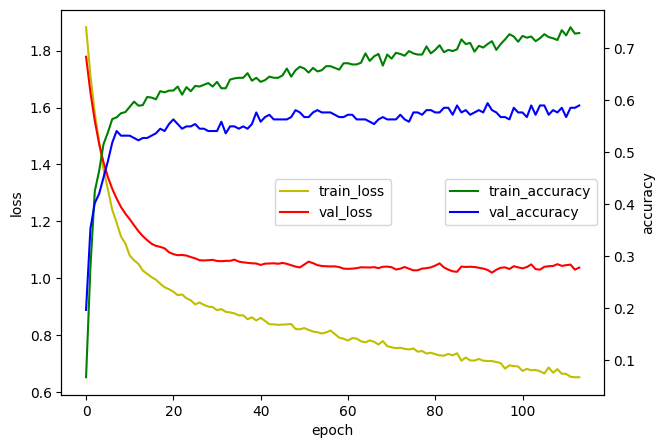

In [27]:
import matplotlib.pyplot as plt
fig, loss_ax = plt.subplots(figsize=(7,5))
loss_ax.plot(hist.history['loss'], 'y', label='train_loss')
loss_ax.plot(hist.history['val_loss'], 'r', label='val_loss')
acc_ax = loss_ax.twinx()
acc_ax.plot(hist.history['accuracy'], 'g', label='train_accuracy')
acc_ax.plot(hist.history['val_accuracy'], 'b', label='val_accuracy')
loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
acc_ax.set_ylabel('accuracy')
loss_ax.legend(loc='center')
acc_ax.legend(loc='center right')
plt.show()

In [28]:
# 모델 평가
loss_and_acc = model.evaluate(X_test, Y_test, batch_size=100, verbose=0)
print(f'loss: {loss_and_acc[0]:.4f}, accuracy: {loss_and_acc[1]:.4f}')

loss: 0.9980, accuracy: 0.6250


In [33]:
# 저장 모델과 비교
model1 = load_model('./model09/wine-093-loss1.0285-acc0.5938.h5')
loss_and_acc1 = model1.evaluate(X_test, Y_test, verbose=0)
print(f'loss: {loss_and_acc1[0]:.4f}, accuracy: {loss_and_acc1[1]:.4f}')

loss: 0.9936, accuracy: 0.6146


In [34]:
# 모델 저장
model.save('model09/wine.h5')

In [38]:
# 교차표 (실제값과 예측값)
real = Y_test.argmax(axis=1)+3 # 실제값 // +3으로 항목 일치
# real = np.argmax(Y_test, axis=1)
pred = model.predict(X_test).argmax(axis=1)+3 #예측값 // +3으로 항목 일치
# pred = np.argmax(model.predict(X_test), axis=1)

pd.crosstab(real, pred, rownames=['real'], colnames=['pred'])

15/15 [==============================] - 0s 2ms/step


pred,5,6,7
real,,,
3,3,0,0
4,9,6,1
5,148,54,2
6,56,123,13
7,4,27,29
8,0,1,4


In [39]:
X_redwine[0]

array([ 7.4   ,  0.7   ,  0.    ,  1.9   ,  0.076 , 11.    , 34.    ,
        0.9978,  3.51  ,  0.56  ,  9.4   ])

In [43]:
input_data = [7.4, 0.7,0, 1.9, 0.076, 11, 34,0.9978, 3.51, 0.56, 9.4]
scaled_data = scaler.transform([input_data])
scaled_data

array([[-0.52835961,  0.96187667, -1.39147228, -0.45321841, -0.24370669,
        -0.46619252, -0.37913269,  0.55827446,  1.28864292, -0.57920652,
        -0.96024611]])

In [46]:
# 2번 인덱스가 5등급인 거라...
model.predict(scaled_data).argmax(axis=1) + 3

1/1 [==============================] - 0s 17ms/step


array([5], dtype=int64)